In [3]:
import pandas as pd
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import pickle as p

## Introduction
This notebook makes charts for the reference model

## Data

In [5]:
df = pd.read_csv('/Users/robertarbon/OneDrive - University of Bristol/Research/AADH/outputs/bond_distances.csv')
dt = df['t (ns)'][1]-df['t (ns)'][0]
dt

0.01

In [6]:
def split_df(df, cols, site='H'):
    X = []
    for k, v in df.loc[df['Site']==site, :].groupby('Trajectory'):
        X.append(v.loc[:, cols].values)
    return X

X_d = split_df(df, ['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H'], site='D')
X_h = split_df(df, ['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H'], site='H')

TICA 

In [7]:
tica_d = pm.coordinates.tica(X_d, lag=int(0.1/dt))
Y_d = tica_d.get_output()
tica_h = pm.coordinates.tica(X_h, lag=int(0.1/dt))
Y_h = tica_h.get_output()

Cluster

In [8]:
cluster_d = p.load(open('/Users/robertarbon/OneDrive - University of Bristol/Research/AADH/msms/'\
            'reference_model_reaction_coordinates/as_d_cluster.p', 'rb'))
cluster_h = p.load(open('/Users/robertarbon/OneDrive - University of Bristol/Research/AADH/msms/'\
            'reference_model_reaction_coordinates/as_h_cluster.p', 'rb'))

In [9]:
dtrajs_d = cluster_d.dtrajs
dtrajs_h = cluster_h.dtrajs

Compute its vs lags

In [10]:
its_10_h = p.load(open('/Users/robertarbon/OneDrive - University of Bristol/Research/AADH/msms/'\
            'reference_model_reaction_coordinates/as_h_its_10.p', 'rb'))
its_10_d = p.load(open('/Users/robertarbon/OneDrive - University of Bristol/Research/AADH/msms/'\
            'reference_model_reaction_coordinates/as_d_its_10.p', 'rb'))

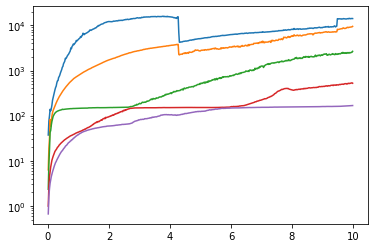

In [11]:
plt.plot(its_10_h['lags']*dt, its_10_h['timescales']*dt)
plt.yscale('log')

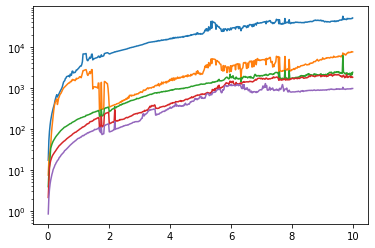

In [12]:
plt.plot(its_10_d['lags']*dt, its_10_d['timescales']*dt)
plt.yscale('log')

In [13]:
stride = 10
sample = [np.ascontiguousarray(x[::stride]) for x in dtrajs_d]
bmms_d = []
for lag in [1, 2, 3]:
    mm = pm.msm.bayesian_markov_model(sample, lag=int(lag/dt/stride))
    bmms_d.append(mm)
# bmms_d = [pm.msm.bayesian_markov_model(sample, lag=int(x/dt/stride)) for x in [1, 2, 3]]

# sample = [np.ascontiguousarray(x[::stride]) for x in dtrajs_h]
# bmms_h = [pm.msm.bayesian_markov_model(sample, lag=int(x/dt/stride)) for x in [1, 2, 3]]


In [ ]:
?pm.msm.its

In [ ]:
its_h_b = pm.msm.its(dtrajs_h, lags=(np.array([1, 2, 3])/dt).astype(int), errors='bayes')

## Fit model
if previous code as run just start here. 


In [ ]:
cluster = p.load(file=open('reference_model/as_d_cluster.p', 'rb'))
dtrajs = cluster.dtrajs

In [ ]:
def plot(i, j, site='D', **kwargs):
    if(site=='H'):
        states = h_cols
    else:
        states = None
        
    X = df.loc[df['Site']==site, states].values
#     fig, ax = plt.subplots()
    fig, ax = pm.plots.plot_free_energy(X[:, i], X[:, j], cmap='viridis_r', **kwargs)
    ax.set_ylabel(states[j])
    ax.set_xlabel(states[i])
    return ax

In [ ]:
# mm01 = pm.msm.estimate_markov_model(dtrajs, lag = int(0.1/dt))
mm = pm.msm.estimate_markov_model(dtrajs, lag = int(5/dt))

In [ ]:
with sns.plotting_context('paper', font_scale=1.25):
    fig = plt.figure(figsize=(6,8))
    sns.set_style('white')
    m = mm
    for ix, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        ax = fig.add_subplot(3,1, ix+1)
        if ix == 2:
            cbar=True
        else: 
            cbar=False
#         plot(i, j, 'H', )
#         pm.plots.plot_free_energy(np.concatenate(Y)[:, i], np.concatenate(Y)[:, j], cmap='viridis_r', 
#                                   **{'avoid_zero_count': True, 'levels': [0,1,2,3,4,5, 6,7, 8, 9, 10], 
#                            'ax': ax, 'cbar': cbar, 'alpha':0.5})
        
        c = ax.scatter(cluster.cluster_centers_[m.active_set, i], 
                       cluster.cluster_centers_[m.active_set, j], 
                       c=1*(m.eigenvectors_right()[:, 2]>0),
                      alpha=1)
        if ix==2:
            plt.colorbar(c)
        
    plt.tight_layout()